<a href="https://colab.research.google.com/github/Marjola1/MERN/blob/main/DataMiningLab_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install pm4py scikit-learn pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

df = pd.read_csv("/content/Hotel_Reservation_BPMN_Diverse_v2.csv")


df = df.rename(columns={
    "CaseID": "case:concept:name",
    "Activity": "concept:name",
    "Timestamp": "time:timestamp"
})

df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
df = df.sort_values(["case:concept:name", "time:timestamp"])

df = dataframe_utils.convert_timestamp_columns_in_df(df)

log = log_converter.apply(df, variant=log_converter.Variants.TO_EVENT_LOG)

df.head()



,case:concept:name,concept:name,InitialStatus,FinalStatus,ProcessFlow,time:timestamp,RoomType,CheckInDate,CheckOutDate,TotalAmount,PaymentMethod,StayDuration,RoomStatus,CustomerType,DiscountApplied,RefundRequested,RefundDaysBeforeCheckIn,RefundStatus
0,1,Reservation Inquiry,Pending,Received,Start -> Reservation Inquiry,2026-02-01 11:00:00+00:00,Suite,2026-02-06 00:00:00+00:00,2026-02-09 00:00:00+00:00,660.0,Credit Card,3,NaN,Individual,0%,No,NaN,NaN
1,1,Availability Check,Waiting,Available,Reservation Inquiry -> Availability Check,2026-02-01 11:15:00+00:00,Suite,2026-02-06 00:00:00+00:00,2026-02-09 00:00:00+00:00,660.0,PayPal,3,NaN,Individual,0%,No,NaN,NaN
2,1,Room Selection,Not Started,Selected,Availability Check -> Room Selection,2026-02-01 11:25:00+00:00,Suite,2026-02-06 00:00:00+00:00,2026-02-09 00:00:00+00:00,660.0,PayPal,3,NaN,Individual,0%,No,NaN,NaN
3,1,Guest Information Collection,Pending,Completed,Room Selection -> Guest Information,2026-02-01 11:35:00+00:00,Suite,2026-02-06 00:00:00+00:00,2026-02-09 00:00:00+00:00,660.0,PayPal,3,NaN,Individual,0%,No,NaN,NaN
4,1,Payment Processing,Waiting,Authorized,Guest Information -> Payment Processing,2026-02-01 12:05:00+00:00,Suite,2026-02-06 00:00:00+00:00,2026-02-09 00:00:00+00:00,660.0,Credit Card,3,NaN,Individual,0%,No,NaN,NaN


In [9]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

net_alpha, im_alpha, fm_alpha = alpha_miner.apply(log)
net_heur, im_heur, fm_heur = heuristics_miner.apply(log)



In [4]:

first_trace = log[0]
first_event = first_trace[0]
print(first_event.keys())
print(first_event["concept:name"], first_event["time:timestamp"])


KeysView({'concept:name': 'Reservation Inquiry', 'InitialStatus': 'Pending', 'FinalStatus': 'Received', 'ProcessFlow': 'Start -> Reservation Inquiry', 'time:timestamp': Timestamp('2026-02-01 11:00:00+0000', tz='UTC'), 'RoomType': 'Suite', 'CheckInDate': Timestamp('2026-02-06 00:00:00+0000', tz='UTC'), 'CheckOutDate': Timestamp('2026-02-09 00:00:00+0000', tz='UTC'), 'TotalAmount': 660.0, 'PaymentMethod': 'Credit Card', 'StayDuration': 3, 'RoomStatus': nan, 'CustomerType': 'Individual', 'DiscountApplied': '0%', 'RefundRequested': 'No', 'RefundDaysBeforeCheckIn': nan, 'RefundStatus': nan})
Reservation Inquiry 2026-02-01 11:00:00+00:00


In [5]:
!pip install -q pm4py==2.7.11


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.8 MB/s eta 0:00:00


In [10]:
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision

# Fitness (alignment-based)
fit_alpha = replay_fitness.apply(log, net_alpha, im_alpha, fm_alpha)["log_fitness"]
fit_heur  = replay_fitness.apply(log, net_heur,  im_heur,  fm_heur )["log_fitness"]

# Precision
prec_alpha = precision.apply(log, net_alpha, im_alpha, fm_alpha)
prec_heur  = precision.apply(log, net_heur,  im_heur,  fm_heur )

print("Alpha  -> fitness:", fit_alpha, " precision:", prec_alpha)
print("Heur   -> fitness:", fit_heur,  " precision:", prec_heur)


replaying log with TBR, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/10 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/21 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/21 [00:00<?, ?it/s]

Alpha  -> fitness: 0.8242424242424242  precision: 0.96
Heur   -> fitness: 0.9504683168316832  precision: 0.8869565217391304


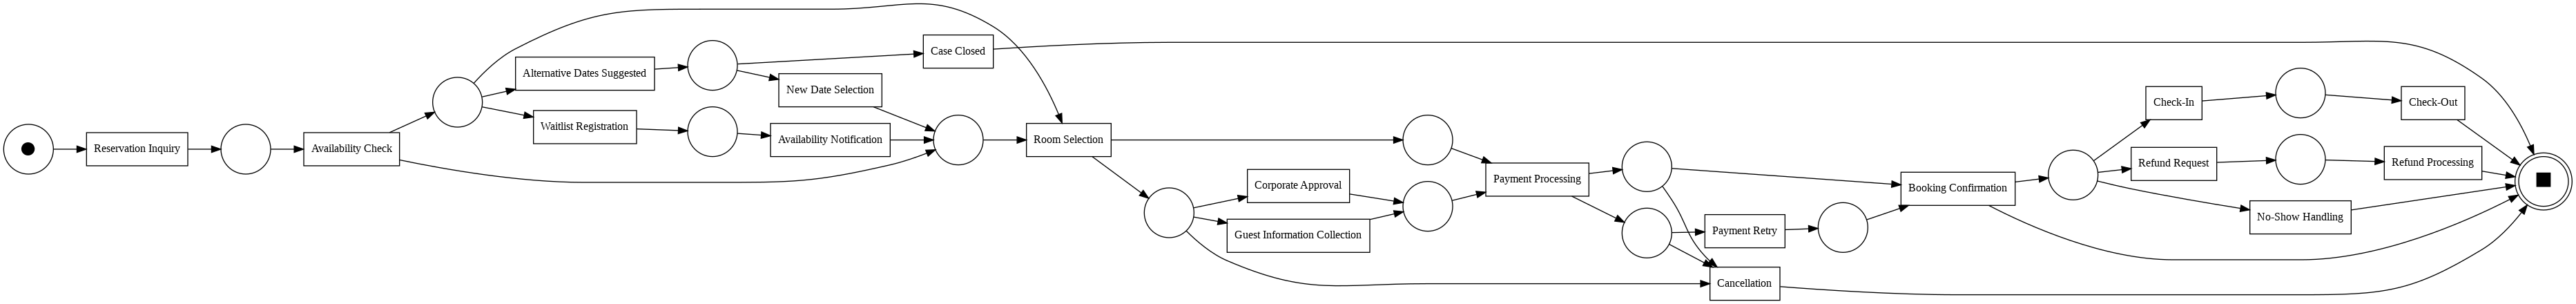

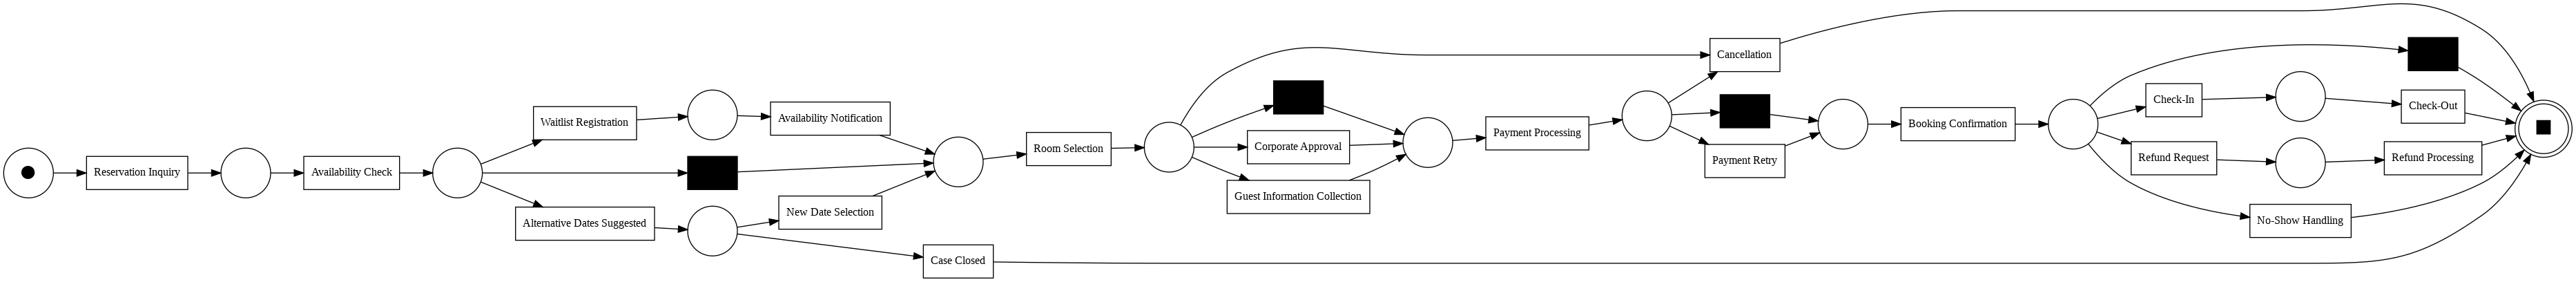

In [11]:
import pm4py

pm4py.view_petri_net(net_alpha, im_alpha, fm_alpha)
pm4py.view_petri_net(net_heur, im_heur, fm_heur)


In [12]:
import pandas as pd

case_features = df.groupby("case:concept:name").agg(
    num_events=("concept:name", "count"),
    num_unique_activities=("concept:name", "nunique"),
    start_time=("time:timestamp", "min"),
    end_time=("time:timestamp", "max")
)

case_features["total_duration_minutes"] = (
    case_features["end_time"] - case_features["start_time"]
).dt.total_seconds() / 60

# Keep only numeric columns for clustering
case_features = case_features.drop(columns=["start_time", "end_time"])

case_features.head()


,num_events,num_unique_activities,total_duration_minutes
case:concept:name,,,
1,8,8,100.0
2,8,8,140.0
3,5,5,60.0
4,5,5,95.0
5,7,7,105.0


In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(case_features)


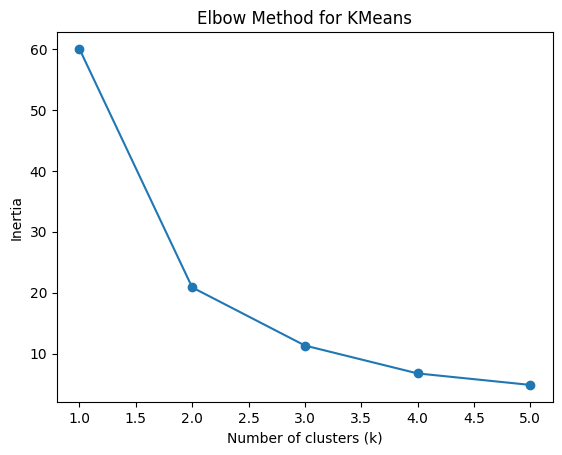

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 6)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(list(K_range), inertia, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")
plt.show()


In [15]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")

case_features["cluster"] = kmeans.fit_predict(X_scaled)

case_features.head()


,num_events,num_unique_activities,total_duration_minutes,cluster
case:concept:name,,,,
1,8,8,100.0,0
2,8,8,140.0,0
3,5,5,60.0,1
4,5,5,95.0,1
5,7,7,105.0,0


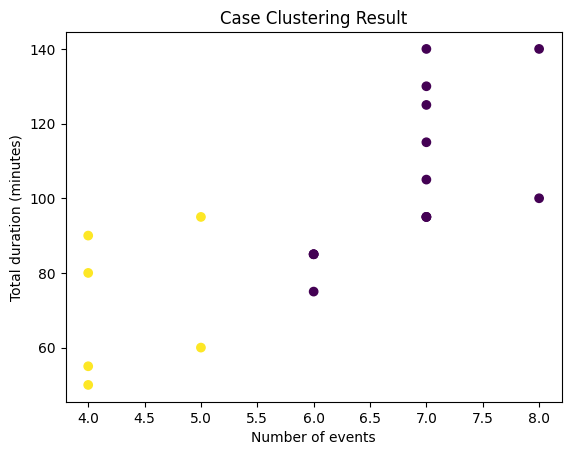

In [16]:
plt.scatter(
    case_features["num_events"],
    case_features["total_duration_minutes"],
    c=case_features["cluster"]
)

plt.xlabel("Number of events")
plt.ylabel("Total duration (minutes)")
plt.title("Case Clustering Result")
plt.show()


In [17]:
case_features["cluster"].value_counts()


,count
cluster,
0,14
1,6


In [18]:
case_features.groupby("cluster").mean()


,num_events,num_unique_activities,total_duration_minutes
cluster,,,
0,6.857143,6.857143,105.000000
1,4.333333,4.333333,71.666667
